#### Multiclass Classification of J Gene Type
Classify the J Gene of a given CDR3 sequence using different machine/deep learning models and compare the results.
The input CDR3 sequences are either embedded using CVC or converted to one-hot encoding.

In [1]:
cd ..

/home/romi/projects/cvc


In [2]:
%load_ext autoreload
%autoreload 2

In [29]:
import os, sys
import collections
import lab_notebooks.utils
import matplotlib.pyplot as plt
import tqdm
import pandas as pd
import matplotlib
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import torch

SRC_DIR = "cvc"
assert os.path.isdir(SRC_DIR), f"Cannot find src dir: {SRC_DIR}"
sys.path.append(SRC_DIR)
from cvc import model_utils
from cvc import plot_utils
from lab_notebooks.utils import TRANSFORMER, DEVICE, DATA_DIR
MODEL_DIR = os.path.join(SRC_DIR, "models")
sys.path.append(MODEL_DIR)

FILT_EDIT_DIST = True

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots/CDR3_data_plots")
if not os.path.isdir(PLOT_DIR):
    os.makedirs(PLOT_DIR)
PLOT_DIR

'plots/CDR3_data_plots'

#### Load Data

In [4]:
gene_type = 'J' #'V'
load_csv = False

In [5]:
if gene_type == 'J':
    data_dir = DATA_DIR + "j_gene_embeddings.csv"
    data_dir_full = DATA_DIR + 'jgene_embed_full_data.csv'
    gene_column = 'jGeneName'
    output_path = './jgene_data_embeddings_with_label_and_sequence.csv'
    input_path = './jgene_data_embeddings_with_label_and_sequence.csv'
else:
    data_dir = DATA_DIR + "v_gene_embeddings.csv"
    data_dir_full = DATA_DIR + 'vgene_public_specific_data.csv'
        #'vgene_data_classfy1.csv' #vgene_embed_full_data.csv'
    gene_column = 'vGeneName'
    output_path = './vgene_public_specific_data_embeddings_with_label_and_sequence.csv'
    input_path = './vgene_data_embeddings_with_label_and_sequence.csv'

In [6]:
# read data
gene_data = pd.read_csv(data_dir_full, engine="pyarrow")

In [ ]:
gene_data = gene_data[['Sequences', 'Appearances', 'Private_Public_label', gene_column]]
gene_data

In [8]:
collections.Counter(gene_data['Private_Public_label'])

Counter({0: 943758, 1: 135778})

In [9]:
collections.Counter(gene_data[gene_column])

Counter({'TCRBJ02-03': 102612,
         'TCRBJ02-07': 160321,
         'TCRBJ01-01': 123659,
         'TCRBJ02-05': 83612,
         'TCRBJ02-02': 73979,
         'TCRBJ01-05': 79326,
         'TCRBJ01-02': 127798,
         'TCRBJ02-01': 148422,
         'TCRBJ01-03': 39829,
         'TCRBJ02-06': 17070,
         'TCRBJ01-06': 52723,
         'TCRBJ01-04': 51858,
         'TCRBJ02-04': 18327})

#### Create subset with equall distribution of genes

In [10]:
# extract sequences that do not have *
gene_data_to_use = [seq for seq in gene_data['Sequences'] if '*' not in seq]
len(gene_data_to_use)

1049813

In [11]:
gene_data_edit = gene_data

In [12]:
# leave the sequences that do not have *
gene_data_edit = gene_data_edit.loc[gene_data_edit['Sequences'].isin(gene_data_to_use)]
len(gene_data_edit)

1049813

In [13]:
# convert label column to numpy array
gene_label_array = gene_data_edit[gene_column].to_numpy()
print(gene_label_array)

['TCRBJ02-03' 'TCRBJ02-03' 'TCRBJ02-03' ... 'TCRBJ02-04' 'TCRBJ02-04'
 'TCRBJ02-04']


In [14]:
collections.Counter(gene_data_edit[gene_column])

Counter({'TCRBJ02-03': 99472,
         'TCRBJ02-07': 154523,
         'TCRBJ01-01': 121269,
         'TCRBJ02-05': 80593,
         'TCRBJ02-02': 71939,
         'TCRBJ01-05': 76960,
         'TCRBJ01-02': 125596,
         'TCRBJ02-01': 143646,
         'TCRBJ01-03': 39018,
         'TCRBJ02-06': 16673,
         'TCRBJ01-06': 51687,
         'TCRBJ01-04': 50838,
         'TCRBJ02-04': 17599})

In [15]:
# get minimum count
min_value = min(collections.Counter(gene_data_edit[gene_column]).values())
# sample from each group according to minimum count
sampled_data = gene_data_edit.groupby(gene_column, sort=False).apply(lambda x: x.sample(min_value))
sampled_data

Sequences  Appearances  Private_Public_label  \
jGeneName                                                                   
TCRBJ02-03 19880         CASSIVEPDTQYF            1                     0   
           81734       CSASLAGGRGDTQYF            1                     0   
           99990        CASSSGASGPTQYF            1                     0   
           39448        CAISVQGKADTQYF            1                     0   
           58090       CASSQGHSVTDTQYF            1                     0   
...                                ...          ...                   ...   
TCRBJ02-04 1077854       CASRETSGAIQYF            1                     0   
           1069643    CATSREFSLAKNIQYF            1                     0   
           1074229  CASSSPRLAGYGGNIQYF            1                     0   
           1061597       CASSFDSPTIQYF            1                     0   
           1070786       CAFSDRDKNIQYF            1                     0   

                     jGeneName  
jGeneName                       
TCRBJ02-03 19880    TCRBJ02-03  
           81734    TCRBJ02-03  
           99990    TCRBJ02-03  
           39448    TCRBJ02-03  
           58090    TCRBJ02-03  
...                        ...  
TCRBJ02-04 1077854  TCRBJ02-04  
           1069643  TCRBJ02-04  
           1074229  TCRBJ02-04  
           1061597  TCRBJ02-04  
           1070786  TCRBJ02-04  

[216749 rows x 4 columns]

In [16]:
collections.Counter(sampled_data[gene_column])

Counter({'TCRBJ02-03': 16673,
         'TCRBJ02-07': 16673,
         'TCRBJ01-01': 16673,
         'TCRBJ02-05': 16673,
         'TCRBJ02-02': 16673,
         'TCRBJ01-05': 16673,
         'TCRBJ01-02': 16673,
         'TCRBJ02-01': 16673,
         'TCRBJ01-03': 16673,
         'TCRBJ02-06': 16673,
         'TCRBJ01-06': 16673,
         'TCRBJ01-04': 16673,
         'TCRBJ02-04': 16673})

#### Create Embeddings

In [17]:
from cvc.embbeding_wrapper import EmbeddingWrapper

# Create embeddings
embed_wrap = EmbeddingWrapper(TRANSFORMER, DEVICE, sampled_data, batch_size=1024, method="mean", layers=[-1])
embed_wrap.embeddings.shape

Some weights of the model checkpoint at /home/romi/projects/cvc/output_5mil_even_priv_pub were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/212 [00:00<?, ?it/s]

(216749, 768)

In [18]:
# create anndata object
tcrb_embeddings_adata = embed_wrap.create_anndata()
tcrb_embeddings_adata

AnnData object with n_obs × n_vars = 216749 × 768
    obs: 'Sequences', 'Appearances', 'Private_Public_label', 'jGeneName'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [19]:
df_embeddings = pd.DataFrame(embed_wrap.embeddings)

In [20]:
# add gene label to dataframe
df_embeddings_with_label = df_embeddings
df_embeddings_with_label[gene_column]=list(tcrb_embeddings_adata.obs[gene_column])
df_embeddings_with_label['Sequences']=list(tcrb_embeddings_adata.obs['Sequences'])

In [21]:
# export embeddings to csvֿ
df_embeddings_with_label.to_csv(output_path)

In [35]:
# # load from csv
if load_csv==True:
    df_embeddings_with_label = pd.read_csv(input_path)
tcrb_embeddings = df_embeddings_with_label.iloc[:,1:-2].to_numpy()
j_gene_array = df_embeddings_with_label.iloc[:,-2].to_numpy()

##### Plot Embeddings

In [36]:
# if PLOT_J_GENE is 1 then the umap will be colored by the J genes, otherwise it will be colored by the private/public label
PLOT_J_GENE = 0
if gene_type=='J':
    if PLOT_J_GENE==1:
        color_label='jGeneName',
        direct_label=False,
        color_map = ListedColormap(sns.color_palette("Spectral", 13))
        cmap= color_map,
        title="UMAP of Embeddings, Colored by J Genes",
        legend_size=4,
        pdf_title="tcr_model_db_data_umap_j_genes.pdf"
    else:
        color_label='Private_Public_label',
        direct_label=False,
        colors = ['gold', 'darkblue']
        cmap=matplotlib.colors.ListedColormap(colors),
        title="UMAP of Embeddings, Colored by Public/Private Label",
        legend_size=4,
        pdf_title="tcr_model_db_data_umap_j_genes.pdf"

# Plot embeddings
embed_wrap.plot_embedding(
    anndata=tcrb_embeddings_adata,
    color_embed=color_label,
    color_map=cmap,
    title=title,
    legend_size=legend_size,
    plot_pdf_path=os.path.join(PLOT_DIR, pdf_title)
)

AssertionError: 

#### Classification Utils

In [37]:
accuracy_dictionary = {}

In [38]:
TRAIN_RATIO = 0.8
def split_train_test(embeddings, embedding_labels):
    # The data will be divided into 80% training 20% validation
    idx_train = int(len(embeddings) * TRAIN_RATIO)

    indices = np.arange(embeddings.shape[0])
    # Shuffle data
    np.random.shuffle(indices)

    # Separate the images and the labels
    embeddings_shuffle = embeddings[indices]
    embedding_labels_shuffle = embedding_labels[indices]

    # Split to train and validation
    train_embeddings = embeddings_shuffle[:idx_train]
    train_labels = embedding_labels_shuffle[:idx_train]
    validation_embeddings = embeddings_shuffle[idx_train:]
    validation_labels = embedding_labels_shuffle[idx_train:]

    return train_embeddings, train_labels, validation_embeddings, validation_labels

In [39]:
# run if data was read from a csv
embeddings = tcrb_embeddings
embedding_labels = df_embeddings_with_label[gene_column]
print("shape of embeddings: {}\nshape of embedding_labels: {}".format(embeddings.shape,embedding_labels.shape))

shape of embeddings: (216749, 767)
shape of embedding_labels: (216749,)


In [40]:
train_embeddings, embed_train_labels, validation_embeddings, embed_validation_labels = split_train_test(embeddings, embedding_labels)
train_embeddings.shape, embed_train_labels.shape, validation_embeddings.shape, embed_validation_labels.shape

/tmp/ipykernel_29337/855962393.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  train_labels = embedding_labels_shuffle[:idx_train]
/tmp/ipykernel_29337/855962393.py:18: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  validation_labels = embedding_labels_shuffle[idx_train:]


((173399, 767), (173399,), (43350, 767), (43350,))

In [41]:
# check for even distribution
collections.Counter(embed_validation_labels), collections.Counter(embed_train_labels)

(Counter({'TCRBJ01-02': 3313,
          'TCRBJ01-01': 3242,
          'TCRBJ01-06': 3348,
          'TCRBJ02-02': 3340,
          'TCRBJ02-05': 3411,
          'TCRBJ02-06': 3352,
          'TCRBJ01-04': 3374,
          'TCRBJ01-05': 3371,
          'TCRBJ02-04': 3304,
          'TCRBJ01-03': 3341,
          'TCRBJ02-01': 3288,
          'TCRBJ02-03': 3366,
          'TCRBJ02-07': 3300}),
 Counter({'TCRBJ01-06': 13325,
          'TCRBJ01-02': 13360,
          'TCRBJ02-07': 13373,
          'TCRBJ02-03': 13307,
          'TCRBJ02-04': 13369,
          'TCRBJ02-02': 13333,
          'TCRBJ01-04': 13299,
          'TCRBJ01-03': 13332,
          'TCRBJ01-05': 13302,
          'TCRBJ02-01': 13385,
          'TCRBJ02-06': 13321,
          'TCRBJ01-01': 13431,
          'TCRBJ02-05': 13262}))

In [42]:
# convert string to integer
def genes_to_num(labels):
    labels_unique = np.unique(labels)
    labels_to_num = pd.factorize(labels_unique)
    return labels_to_num

In [43]:
genes_int_ratio = genes_to_num(embed_train_labels)
# make dictionary of gene to integer
gene_to_num_dictionary = dict(zip(genes_int_ratio[1], genes_int_ratio[0]))
# convert embed_train_labels to integer using dictionary
embed_train_labels_num = [gene_to_num_dictionary[gene] for gene in embed_train_labels]
embed_val_labels_num = [gene_to_num_dictionary[gene] for gene in embed_validation_labels]

#### One-Hot Encoding

In [188]:
# Import Dependencies 
import pandas as pd
import numpy as np

# Function to encode sequences
def encode_seq(sequence, max_cdr3_len):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    integer_encoded = [char_to_int[char] for char in sequence]
    
    # one hot encode
    integer_encoded = torch.tensor(integer_encoded)
    integer_encoded = F.one_hot(integer_encoded, num_classes=len(alphabet))
    
    # pad integer_encoded tensor first dim with zeros up to max_cdr3_len
    integer_encoded = F.pad(integer_encoded, (0,0,0, max_cdr3_len - len(integer_encoded)))
    integer_encoded = integer_encoded.numpy()
    return integer_encoded

In [189]:
# extract sequences
cdr3_sequences = df_embeddings_with_label['Sequences']#tcrb_data_sample['Sequences']
sequences_labels = df_embeddings_with_label[gene_column]
max_cdr3_len = cdr3_sequences.apply(len).max()
max_cdr3_len

27

In [190]:
# split data into train/test
train_seqs, train_labels, validation_seqs, validation_labels = split_train_test(cdr3_sequences.to_numpy(), sequences_labels)
print("shape of training set: {}\nshape of validation set: {}".format(train_seqs.shape, validation_seqs.shape))

shape of training set: (173399,)
shape of validation set: (43350,)


In [191]:
import torch.nn.functional as F
# encode amino acid sequences to one hot vector
encoded_train_seqs = pd.Series(train_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))
encoded_validation_seqs = pd.Series(validation_seqs).apply(lambda x: encode_seq(x, max_cdr3_len))

In [192]:
# Stack list(encoded_train_seqs) in dim 0
train_seqs_stack = np.stack(encoded_train_seqs, axis=0)
valid_seqs_stack = np.stack(encoded_validation_seqs, axis=0)
train_seqs_stack.shape, valid_seqs_stack.shape

((173399, 27, 20), (43350, 27, 20))

In [193]:
# reshape train/validation tensors
train_seqs_stack = train_seqs_stack.reshape(train_seqs_stack.shape[0], -1)
valid_seqs_stack = valid_seqs_stack.reshape(valid_seqs_stack.shape[0], -1)
train_seqs_stack.shape, valid_seqs_stack.shape

((173399, 540), (43350, 540))

In [194]:
genes_int_ratio = genes_to_num(train_labels)
# make dictionary of gene to integer
gene_to_num_dictionary = dict(zip(genes_int_ratio[1], genes_int_ratio[0]))
# convert embed_train_labels to integer using dictionary
train_labels_num = [gene_to_num_dictionary[gene] for gene in train_labels]
val_labels_num = [gene_to_num_dictionary[gene] for gene in validation_labels]

#### xgBoost on Embeddings
Guide on xgBoost - https://towardsdatascience.com/beginners-guide-to-xgboost-for-classification-problems-50f75aac5390


In [ ]:
# feature scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_embeddings = sc.fit_transform(train_embeddings)
validation_embeddings = sc.fit_transform(validation_embeddings)

In [ ]:
accuracy_dictionary['xgBoost'], xgb_preds, xgb_classifier = \
    lab_notebooks.utils.xgb_classify(train_embeddings, embed_train_labels_num, validation_embeddings, embed_val_labels_num)

#### xgBoost - OneHot

In [40]:
# apply xgb on onehot, extract accuracy
accuracy_dictionary['xgBoost_OneHot'], xgb_preds_onehot, xgb_classifier_onehot =\
    lab_notebooks.utils.xgb_classify(train_seqs_stack, train_labels_num, valid_seqs_stack, val_labels_num)

#### LDA

In [41]:
accuracy_dictionary["LDA"], lda_preds, lda_classifier = lab_notebooks.utils.lda_classify(train_embeddings,embed_train_labels_num, validation_embeddings, embed_val_labels_num)
accuracy_dictionary["LDA"]

98.54440599769319

#### LDA - OneHot

In [ ]:
import lab_notebooks.utils
accuracy_dictionary['LDA_OneHot'], lda_preds_onehot, lda_classifier_onehot =\
    lab_notebooks.utils.lda_classify(train_seqs_stack, train_labels_num, valid_seqs_stack, val_labels_num)

#### Plot Results

In [54]:
res_dic = {'model' : ['xgBoost', 'xgBoost', 'xgBoost',
            'xgBoost_OneHot', 'xgBoost_OneHot', 'xgBoost_OneHot',
            'LDA','LDA','LDA', 'LDA_OneHot','LDA_OneHot','LDA_OneHot'],
            'accuracy': [98.34, 98.39, 98.47, 98.2, 98.37, 98.26, 98.4, 98.45, 98.54, 94.9, 94.86, 94.74]}

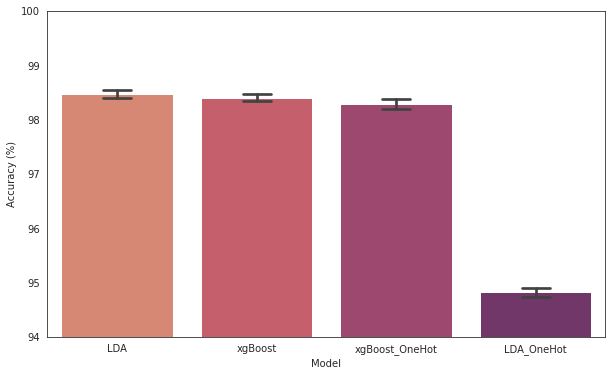

In [71]:
# barplot of accuracy with error bars
df = pd.DataFrame(res_dic)
df = df.sort_values(by='accuracy', ascending=False)
df = df.reset_index(drop=True)
df
# plot
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='model', y='accuracy', data=df, ax=ax, palette="flare",capsize=.2)
# ax.set_title('Accuracy of different classification models')
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model')
ax.set_ylim(94, 100)
plt.show()

In [ ]:
res_dic_1 = {'xgBoost': [98.34, 98.39, 98.47],
             'xgBoost_OneHot': [98.2, 98.37, 98.26],
             'LDA': [98.4, 98.45, 98.54],
             'LDA_OneHot': [94.9, 94.86, 94.74]}

In [70]:
# calculate mean accuracy for each model
res_dic_avg = {key: np.mean(value) for key, value in res_dic_1.items()}
res_dic_avg

{'xgBoost': 98.40000000000002,
 'xgBoost_OneHot': 98.27666666666666,
 'LDA': 98.46333333333335,
 'LDA_OneHot': 94.83333333333333}

### Deep Neural Network

#### Deep Learning Model on Embeddings

In [44]:
# set flag to run with onehot
DNN_ONEHOT = 0

In [45]:
# defining dataset class
from torch.utils.data import Dataset, DataLoader
class dataset(Dataset):
    def __init__(self,x, y):
        # self.x = torch.tensor(x, dtype=torch.float32).to('cuda')
        # self.y = torch.tensor(y, dtype=torch.float32).to('cuda')
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.length = self.x.shape[0]
        assert self.x.shape[0] == self.y.shape[0]
        
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def __len__(self):
        return self.length

In [46]:
BATCH_SIZE = 1024

# create datasets
if DNN_ONEHOT==0:
    trainset = dataset(train_embeddings, embed_train_labels_num)
    validset = dataset(validation_embeddings, embed_val_labels_num)
else:
    trainset = dataset(train_seqs_stack, train_labels_num)
    validset = dataset(valid_seqs_stack, val_labels_num)

# DataLoader with 10 workers
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=10, pin_memory=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE, num_workers=10, pin_memory=True)

/opt/conda/envs/tcrbert/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [47]:
#defining the network
from torch import nn
from torch.nn import functional as F

class Net(nn.Module):
    def __init__(self, input_shape, num_classes=len(collections.Counter(gene_data_edit[gene_column]))):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_shape,64)
        self.fc2 = nn.Linear(64,32)
        self.fc3 = nn.Linear(32,num_classes)

    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
# hyper parameters
learning_rate = 0.00001

# set input shape
input_shape = train_embeddings.shape[1]
if DNN_ONEHOT:
    input_shape = train_seqs_stack.shape[1]

# Model , Optimizer, Loss
device = 'cpu'
model = Net(input_shape=input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [49]:
params = list(model.parameters())
print(len(params))

6


In [50]:
# calculate accuracy multi-class
def calculate_accuracy(y_pred, y_test):
    y_pred_tag = torch.argmax(y_pred, dim=1)
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [51]:
def train_classify(model, trainloader, optimizer):
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.train()
    for train_embedding, train_label in tqdm.notebook.tqdm(trainloader, total=len(trainloader)):
        # option to move train_embedding, train_label to gpu here
        # calculate output
        train_embedding, train_label =  train_embedding.to(device), train_label.to(device)
        output = model(train_embedding)

        # calculate loss
        loss = F.cross_entropy(output, train_label.reshape(-1).long())
        
        # accuracy
        acc = calculate_accuracy(output, train_label)
        
        # backprop
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        count += len(train_label)
    return epoch_loss / len(trainloader), epoch_acc / len(trainloader)

In [52]:
def evaluate_classify(model, validloader): 
    epoch_loss = 0
    epoch_acc = 0
    count = 0
    model.eval()
    label_list = []
    pred_label_list = []
    with torch.no_grad(): 
        for valid_embedding, valid_label in tqdm.notebook.tqdm(validloader, total=len(validloader)):
            # option to move valid_embedding, valid_label to gpu here
            valid_embedding, valid_label = valid_embedding.to(device), valid_label.to(device)
            # calculate output
            output = model(valid_embedding)

            # calculate loss
            loss = F.cross_entropy(output, valid_label.reshape(-1).long())

            # accuracy
            acc = calculate_accuracy(output, valid_label)
            
            # add to lists for confusion matrixv
            label_list.append(valid_label.cpu())
            pred_label_list.append(output.cpu())
            
            #acc = calculate_accuracy(output, valid_label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            count += len(valid_label)
    return (epoch_loss / len(validloader), epoch_acc / len(validloader),
            torch.cat(label_list, dim=0), 
            torch.cat(pred_label_list, dim=0))

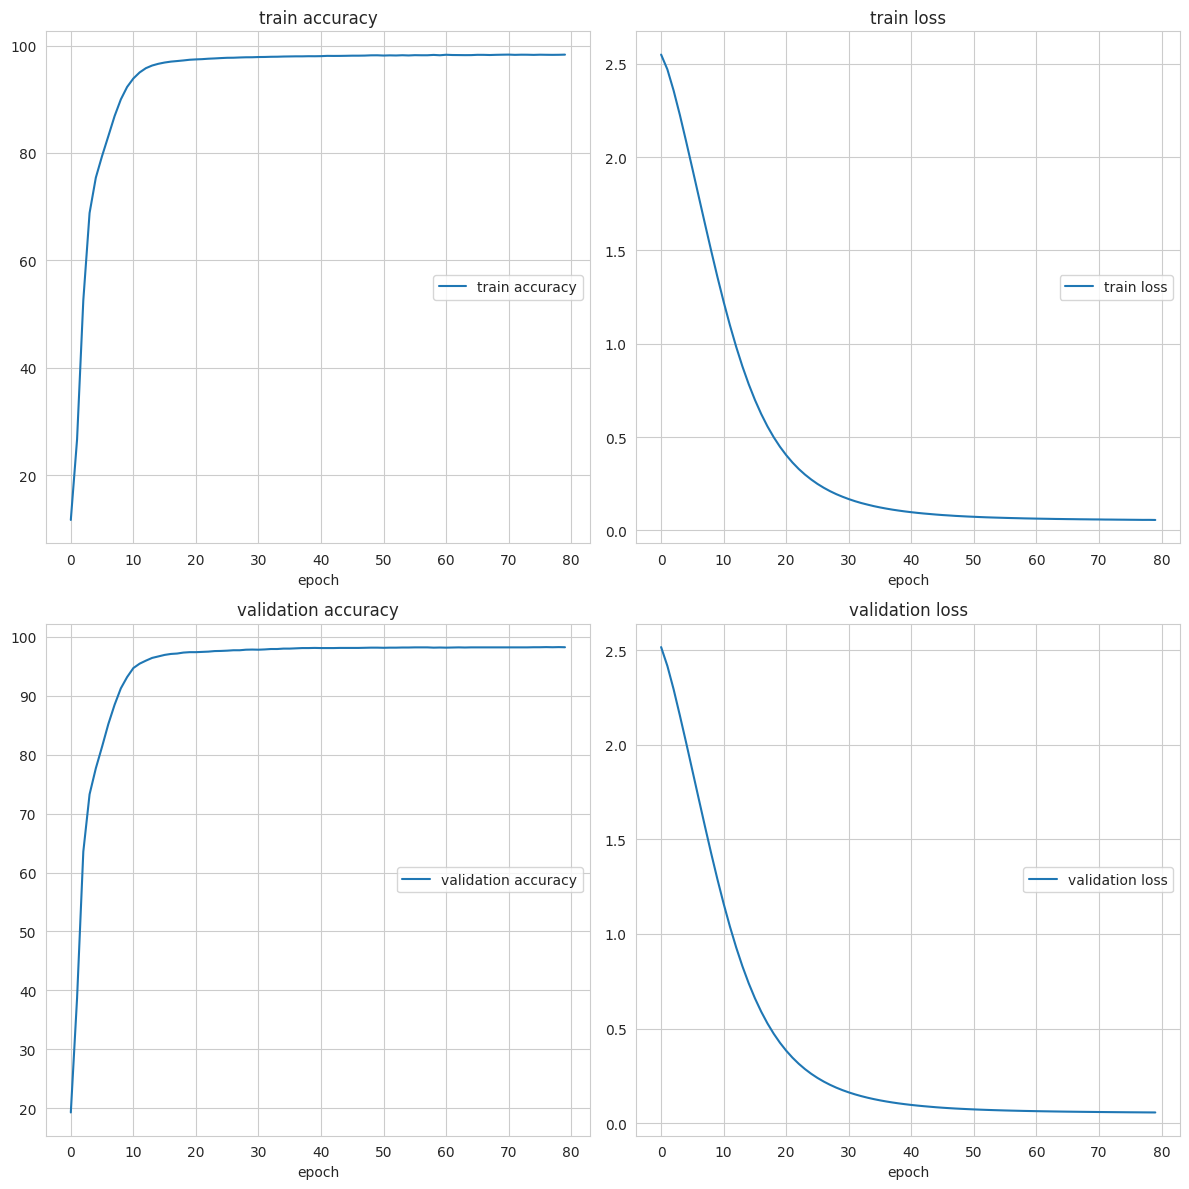

train accuracy
	train accuracy   	 (min:   11.641, max:   98.318, cur:   98.312)
train loss
	train loss       	 (min:    0.056, max:    2.549, cur:    0.056)
validation accuracy
	validation accuracy 	 (min:   19.256, max:   98.279, cur:   98.256)
validation loss
	validation loss  	 (min:    0.056, max:    2.516, cur:    0.056)


In [53]:
from livelossplot import PlotLosses
liveloss1_class = PlotLosses()
logs_class = {}
EPOCHS=80

for epoch in range(EPOCHS):
    print('starting epoch {}'.format(epoch))
    train_loss, train_acc = train_classify(model, trainloader, optimizer)
    print('Epoch {} of {}, Train Loss: {:.3f}'.format(
            epoch+1, EPOCHS, train_loss))

    print('Epoch {} of {}, Train Accuracy: {:.3f}'.format(
          epoch+1, EPOCHS, train_acc))

    logs_class['train loss'] = train_loss
    logs_class['train accuracy'] = train_acc

    valid_loss, valid_acc, label_list, pred_label_list  = evaluate_classify(model, validloader)
    print('Epoch {} of {}, Validate Loss: {:.3f}'.format(
        epoch+1, EPOCHS, valid_loss))

    print('Epoch {} of {}, Validate Accuracy: {:.3f}'.format(
        epoch+1, EPOCHS, valid_acc))

    logs_class['validation loss'] = valid_loss
    logs_class['validation accuracy'] = valid_acc

    liveloss1_class.update(logs_class)
    liveloss1_class.send()

In [54]:
# Save model
PATH = "./classifiers/j_gene_classifier.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}, PATH)

#### Plot Results

In [212]:
dnn_dic_1 = {'DNN': [98.7, 98.6, 98.412],
             'DNN_OneHot': [89.7, 90.8,90.82]}


# calculate mean accuracy for each model
res_dnn_avg = {key: np.mean(value) for key, value in dnn_dic_1.items()}
res_dnn_avg

{'DNN': 98.57066666666667, 'DNN_OneHot': 90.44}

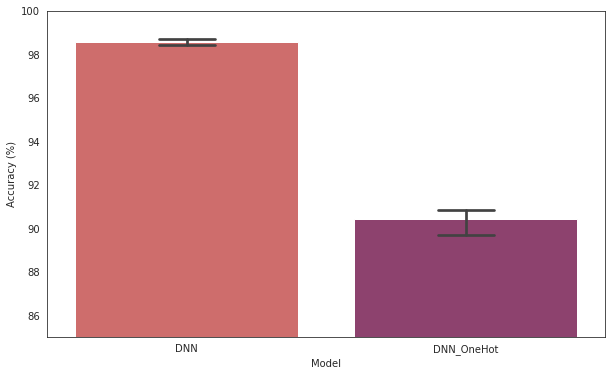

In [210]:
# dictionary
dnn_dic = {'model' : ['DNN', 'DNN', 'DNN',
                      'DNN_OneHot', 'DNN_OneHot', 'DNN_OneHot'],
           'accuracy': [98.7, 98.6, 98.412,89.7, 90.8,  90.82]}

# barplot of accuracy with error bars
df = pd.DataFrame(dnn_dic)
df = df.sort_values(by='accuracy', ascending=False)
df = df.reset_index(drop=True)
df
# plot
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='model', y='accuracy', data=df, ax=ax, palette="flare",capsize=.2)
# ax.set_title('Accuracy of different classification models')
ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Model')
ax.set_ylim(85, 100)
plt.show()